# 0. Introduction

This notebook builds and backtests a **dynamic multi-asset risk parity portfolio** <br>
using a simple inverse-volatility allocation rule. Risk parity targets balanced <br>
risk contribution across assets (rather than equal capital allocation) and is <br>
commonly used as a diversification and risk-management framework in multi-asset <br>
portfolios.

The workflow is intentionally end-to-end and reproducible:
- Load and clean historical price data (multi-asset futures proxies)
- Resample to monthly frequency
- Compute returns and rolling volatility estimates
- Construct inverse-volatility weights and apply a one-period lag to avoid <br>
look-ahead bias
- Generate portfolio returns and evaluate performance

### Outputs
The notebook produces:
- Time-varying portfolio weights
- Portfolio return series and equity curve
- Risk and drawdown diagnostics
- Standard performance metrics (annualized return/volatility, Sharpe, Sortino, <br>
Calmar, max drawdown, skew, kurtosis)
- Visualizations to interpret behaviour across market regimes

### Notes on usage
- Run the notebook top-to-bottom for a clean, reproducible backtest.
- Key assumptions (frequency, volatility window, risk-free rate treatment) are <br>
stated where used.
- The asset universe and parameters are easy to extend for sensitivity testing.


# 1. Import Libraries

In [6]:
# Notebook Imports
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import date
from dateutil.relativedelta import relativedelta


# 2. Download Financial Data
Download front-month futures data for S&P500, 10-year Treasuries, gold, and US <br>
dollar using the `yfinance` library.

In [14]:
# Download front-month futures data
START_DATE = "2015-12-30"
END_DATE = date.today()
THREE_MONTHS_AGO = date.today() - relativedelta(months=3)

TICKERS = ['ES=F', 'ZN=F', 'GC=F', 'DX=F']
data = yf.download(
    tickers=TICKERS, 
    start=START_DATE,
    end=END_DATE,
    auto_adjust=False
)

# Last 3 months risk-free rate
risk_free_rates = yf.download(
    tickers='^IRX', 
    start=THREE_MONTHS_AGO,
    end=END_DATE,
    auto_adjust=False
)["Adj Close"]

avg_risk_free_rate = (risk_free_rates.mean() / 100)[0]

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\Wayne.Bartlett\AppData\Local\Temp\ipykernel_20748\3589090632.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_risk_free_rate = (risk_free_rates.mean() / 100)[0]


### 3. Resample Data

In this section, I aim to reduce the noise in the daily financial data by <br>
resampling it to a monthly frequency. <br>
Resampling is a common technique in time series analysis, allowing us to aggregate <br>
data points over a specified time period. This helps in smoothing out short-term <br>
fluctuations and making the data more manageable for analysis.


In [15]:
# Resample data to monthly frequency
data = data.resample('ME').last()
# Convert index to datetime
data.index = pd.to_datetime(data.index)

In [16]:
data.head()

Price       Adj Close                                       Close          \
Ticker           DX=F    ES=F         GC=F        ZN=F       DX=F    ES=F   
Date                                                                        
2015-12-31  98.745003  2035.5  1060.300049  125.906250  98.745003  2035.5   
2016-01-31  99.652000  1930.0  1116.400024  129.578125  99.652000  1930.0   
2016-02-29  98.219002  1929.5  1233.900024  130.906250  98.219002  1929.5   
2016-03-31  94.578003  2051.5  1234.199951  130.390625  94.578003  2051.5   
2016-04-30  93.054001  2059.0  1289.199951  130.062500  93.054001  2059.0   

Price                                     High           ...          Low  \
Ticker             GC=F        ZN=F       DX=F     ES=F  ...         GC=F   
Date                                                     ...                
2015-12-31  1060.300049  125.906250  98.845001  2057.75  ...  1058.500000   
2016-01-31  1116.400024  129.578125  99.879997  1933.00  ...  1108.800049   
2016-02-29  1233.900024  130.906250  98.389999  1956.25  ...  1218.599976   
2016-03-31  1234.199951  130.390625  95.014999  2059.75  ...  1224.500000   
2016-04-30  1289.199951  130.062500  93.720001  2076.00  ...  1267.199951   

Price                        Open                                   Volume  \
Ticker            ZN=F       DX=F     ES=F         GC=F        ZN=F   DX=F   
Date                                                                         
2015-12-31  125.625000  98.260002  2055.25  1061.900024  125.703125  39008   
2016-01-31  128.968750  98.680000  1878.75  1114.400024  129.062500  27833   
2016-02-29  130.656250  98.180000  1943.00  1218.599976  130.781250  19439   
2016-03-31  129.953125  94.849998  2055.50  1225.599976  130.046875  20684   
2016-04-30  129.656250  93.720001  2073.75  1267.300049  130.046875  22398   

Price                                     
Ticker           ES=F    GC=F       ZN=F  
Date                                      
2015-12-31  1029390.0    10.0   459340.0  
2016-01-31  2406399.0  6955.0  1692523.0  
2016-02-29  1826411.0   580.0   264215.0  
2016-03-31  1736311.0  3377.0  1138040.0  
2016-04-30  2419757.0   464.0  1496779.0  

[5 rows x 24 columns]

In [11]:
print(type(data.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


### 4. Clean and Prepare Data

In this step, I focus on extracting the relevant data, handling missing values, <br>
and ensuring the data is ready for analysis. Specifically, I subset the adjusted <br>
close prices from the dataset, fill any missing values, and drop rows with unknown <br>
prices.

#### Steps to Clean and Prepare Data

1. **Subset Adjusted Close Prices**     
2. **Fill Missing Values (NaNs)**
3. **Drop Rows with Remaining NaNs**
4. **Ensure Correct Date Formatting**

By following these steps, I will have a clean dataset of adjusted close prices <br>
that is free of missing values and properly formatted for time series analysis.


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 2015-12-31 to 2025-12-31
Freq: ME
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, DX=F)  121 non-null    float64
 1   (Adj Close, ES=F)  121 non-null    float64
 2   (Adj Close, GC=F)  121 non-null    float64
 3   (Adj Close, ZN=F)  121 non-null    float64
 4   (Close, DX=F)      121 non-null    float64
 5   (Close, ES=F)      121 non-null    float64
 6   (Close, GC=F)      121 non-null    float64
 7   (Close, ZN=F)      121 non-null    float64
 8   (High, DX=F)       121 non-null    float64
 9   (High, ES=F)       121 non-null    float64
 10  (High, GC=F)       121 non-null    float64
 11  (High, ZN=F)       121 non-null    float64
 12  (Low, DX=F)        121 non-null    float64
 13  (Low, ES=F)        121 non-null    float64
 14  (Low, GC=F)        121 non-null    float64
 15  (Low, ZN=F)        121 non-null    float64
 16

In [18]:
# Subset adjusted close prices and fill NaNs
prices = data["Adj Close"].ffill().dropna()
# Convert index to datetime
prices.index = pd.to_datetime(prices.index)

In [19]:
print(prices)

Ticker           DX=F     ES=F         GC=F        ZN=F
Date                                                   
2015-12-31  98.745003  2035.50  1060.300049  125.906250
2016-01-31  99.652000  1930.00  1116.400024  129.578125
2016-02-29  98.219002  1929.50  1233.900024  130.906250
2016-03-31  94.578003  2051.50  1234.199951  130.390625
2016-04-30  93.054001  2059.00  1289.199951  130.062500
...               ...      ...          ...         ...
2025-08-31  97.690002  6472.75  3473.699951  112.453125
2025-09-30  97.450996  6738.75  3840.800049  112.500000
2025-10-31  99.629997  6874.00  3982.199951  112.671875
2025-11-30  99.407997  6859.50  4218.299805  113.421875
2025-12-31  97.955002  6944.25  4370.100098  112.640625

[121 rows x 4 columns]


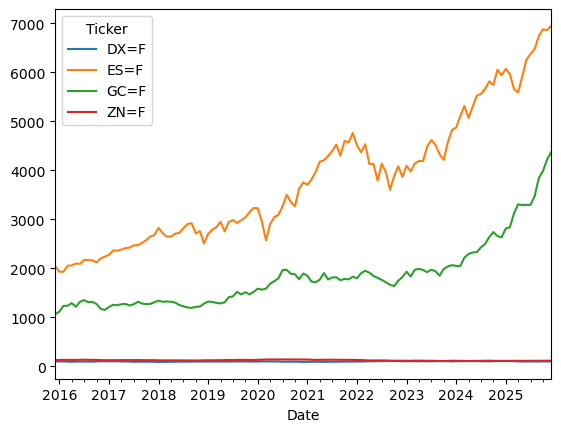

In [20]:
prices.plot()
plt.show()

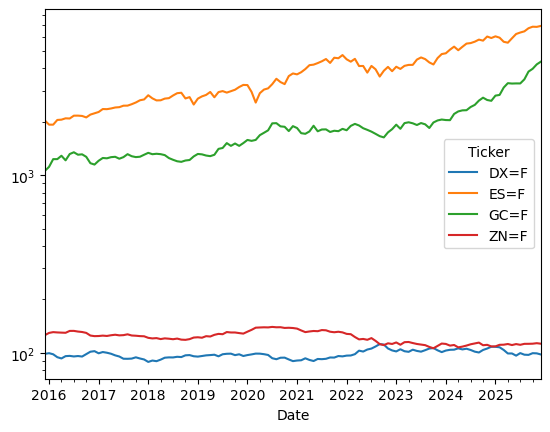

In [21]:
prices.plot()
plt.yscale("log")
plt.show()

### 5. Calculate Returns

In financial analysis, one of the key metrics is the return on an investment, <br>
which shows how much the price of an asset has increased or decreased over a <br>
certain period. I calculate the **arithmetic returns** of the adjusted close prices <br>
to measure this change over time.

#### Steps to Calculate Arithmetic Returns

1. **Understanding Arithmetic Returns:**
   - Arithmetic returns measure the percentage change in the price of an asset <br>
   from one period to the next. 
   - The formula for calculating the arithmetic return for a given period is:

     $
     R_t = \frac{P_t - P_{t-1}}{P_{t-1}}
     $
     
     where:
     - $ R_t $ is the return at time $ t $,
     - $ P_t $ is the price at time $ t $,
     - $ P_{t-1} $ is the price at the previous time period.

   - This formula can be simplified to:
     $
     R_t = \frac{P_t}{P_{t-1}} - 1
     $
   - However, in practice, it is common to use the percentage change function <br>
   provided by Pandas, which handles this calculation efficiently.

2. **Calculate Percentage Change**
3. **Handle Missing Values:**

By following these steps, I will have a series of arithmetic returns that <br>
represent the day-to-day percentage changes in the asset's price, which can be <br>
used for further analysis such as calculating cumulative returns, volatility, or <br>
risk metrics.


In [10]:
# Compute arithmetic returns
returns = None # YOUR CODE HERE

In [ ]:
print(returns)

### 6. Compute Risk-Parity Weights

Risk-parity is an investment strategy that seeks to allocate portfolio weights <br>
in a way that each asset contributes equally to the overall portfolio risk. <br>
This method is especially useful in diversifying risk across different assets <br>
with varying levels of volatility.

#### Steps to Compute Risk-Parity Weights

1. **Understanding Risk-Parity:**
   - The idea behind risk-parity is to allocate more weight to less volatile <br>
   assets and less weight to more volatile assets, thereby equalizing the risk <br>
   contribution of each asset in the portfolio.
   - The weight of each asset in the portfolio is inversely proportional to its <br>
   volatility.

2. **Calculate Rolling Volatility:**
   - Volatility is a statistical measure of the dispersion of returns for a <br>
   given security or market index.
     
3. **Compute Inverse Volatility:**
4. **Normalize Weights:**
   - Once I have the inverse volatilities, I normalize them so that the sum of <br>
   the weights for each time period equals 1. This ensures a proper weight distribution <br>
   across assets.
   - I achieve this by dividing the inverse volatility of each asset by the <br>
   sum of the inverse volatilities across all assets for each time period.
     
5. **Shift Weights for Practical Application:**
   - In a real-world scenario, I can only make investment decisions based on <br>
   information that is available at the time of making the decision. Therefore, <br>
   I shift the computed weights by one period to ensure that the weights at <br>
   time $ t $ are based on data up to $ t-1 $.      
   - This shift ensures that the weights applied are based on historical data <br>
   up to the previous period, which is crucial for avoiding look-ahead bias.

By following these steps, I generate a time series of risk-parity weights that <br>
can be used to allocate assets in a way that balances the risk across the portfolio. <br>
The resulting weights adapt dynamically based on the rolling volatility, ensuring <br>
that each asset contributes equally to the overall risk over time.


In [12]:
def compute_risk_parity_weights(returns, window_size=36):
    # Compute volatility known at time t
    rolling_vol = None # YOUR CODE HERE
    rolling_inverse_vol = None # YOUR CODE HERE
    # Divide inverse volatility by the sum of inverse volatilities
    risk_parity_weights = None # YOUR CODE HERE
    # Shift weights by one period to use only information available at time t
    risk_parity_weights = None # YOUR CODE HERE
    return risk_parity_weights

risk_parity_weights = compute_risk_parity_weights(returns, 36)

In [ ]:
risk_parity_weights.plot()
plt.show()

### 7. Calculate Weighted Returns

Once I have the risk-parity weights, the next step is to calculate the weighted <br>
returns for each asset and then aggregate them to obtain the portfolio returns. <br>
This process allows me to understand how the risk-parity allocation strategy <br>
would have performed over time.

#### Steps to Calculate Weighted Returns

1. **Understanding Weighted Returns:**
   - The weighted return of an asset is calculated by multiplying its individual <br>
   return by the corresponding weight in the portfolio. 
   - The total portfolio return at any given time is the sum of the weighted <br>
   returns of all assets.

2. **Apply Weights to Returns:**
   - I will multiply the returns of each asset by its corresponding risk-parity <br>
   weight for each time period. This will give us the weighted return for each asset.
3. **Handle Missing Data:**
   - I drop any rows with missing values (`NaN`) that may result from the <br>
   multiplication process. This ensures that I only consider time periods with <br>
   complete data.
4. **Aggregate Weighted Returns:**
   - To calculate the portfolio's return at each time period, sum the weighted <br>
   returns across all assets. This gives the overall return of the portfolio <br>
   for each time period.

#### Mathematical Representation:

Given the returns $ r_{i,t} $ for asset $ i $ at time $ t $, and the <br>
risk-parity weight $ w_{i,t} $ for asset $ i $ at time $ t $, the <br>
weighted return for asset $ i $ at time $ t $ is:

$ r_{i,t}^{weighted} = r_{i,t} \times w_{i,t} $

The total portfolio return at time $ t $ is the sum of the weighted returns for <br>
all assets:

$
R_{portfolio,t} = \sum_{i=1}^{n} r_{i,t}^{weighted}
$

Where $ n $ is the number of assets in the portfolio.

By following these steps, I obtain the portfolio returns that reflect the <br>
performance of the risk-parity strategy over time. This provides insights into <br>
how well the strategy balanced risk across different market conditions.


In [14]:
# Calculate weighted returns
weighted_returns = None # YOUR CODE HERE
risk_parity_portfolio_returns = None # YOUR CODE HERE

In [ ]:
print(risk_parity_portfolio_returns)

### 8. Evaluate Portfolio Performance

To assess the performance of the risk-parity portfolio, I compute several key <br>
financial metrics. These metrics will help understand the portfolio's return, <br>
risk, and overall performance characteristics. Below are the details of the <br>
metrics I will calculate, along with the functions used and their corresponding <br>
arguments.

1. **Annualized Mean Return**
   - **Description:** The average return of the portfolio on an annual basis. <br>
   This is useful for understanding the long-term growth rate of the portfolio.
2. **Annualized Volatility**
   - **Description:** A measure of the portfolio's return volatility on an annual <br>
   basis, indicating the degree of variation in returns.
   - **Formula:** 
     $
     \text{Annualized Volatility} = \text{Standard Deviation of Monthly Returns} \times \sqrt{12}
     $
3. **Skewness**
   - **Description:** Skewness measures the asymmetry of the return distribution. <br>
   Positive skewness indicates a distribution with a longer right tail, while <br>
   negative skewness indicates a longer left tail.
4. **Kurtosis**
   - **Description:** Kurtosis measures the "tailedness" of the return distribution. <br>
   High kurtosis indicates a distribution with heavy tails and a sharp peak.
5. **Maximum Drawdown**
   - **Description:** The maximum observed loss from a peak to a trough of the <br>
   portfolio's cumulative returns, before a new peak is attained.
   - **Formula:** 
     $
     \text{Drawdown} = \frac{\text{Cumulative Return} - \text{Running Maximum}}{\text{Running Maximum}}
     $
6. **Sharpe Ratio**
   - **Description:** The Sharpe Ratio measures the risk-adjusted return of the <br>
   portfolio, calculated as the ratio of the portfolio's excess return (over the <br>
   risk-free rate, typically assumed to be 0 in this case) to its volatility.
   - **Formula:** 
     $
     \text{Sharpe Ratio} = \frac{\text{Annualized Mean Return}}{\text{Annualized Volatility}}
     $
7. **Sortino Ratio**
   - **Description:** The Sortino Ratio is a variation of the Sharpe Ratio that <br>
   penalizes only downside volatility, thus providing a better measure of <br>
   risk-adjusted return for portfolios that have asymmetric return distributions.
   - **Formula:** 
     $
     \text{Sortino Ratio} = \frac{\text{Annualized Mean Return}}{\text{Downside Volatility}}
     $
8. **Calmar Ratio**
   - **Description:** The Calmar Ratio measures the risk-adjusted return of a <br>
   portfolio by comparing the annualized return to the maximum drawdown, providing <br>
   insight into performance relative to the worst-case scenario.
   - **Formula:** 
     $
     \text{Calmar Ratio} = \frac{\text{Annualized Mean Return}}{-\text{Maximum Drawdown}}
     $

After calculating these metrics, I display the results to evaluate the performance <br>
of the risk-parity portfolio comprehensively.


In [ ]:
# Evaluate portfolio performance
annual_mean_return = None # YOUR CODE HERE
annual_volatility = None # YOUR CODE HERE
skewness = None # YOUR CODE HERE
kurtosis = None # YOUR CODE HERE

# Compute drawdown
cumulative_returns = None # YOUR CODE HERE
running_max = None # YOUR CODE HERE
drawdown = None # YOUR CODE HERE
max_drawdown = None # YOUR CODE HERE

# Compute Sharpe ratio
sharpe_ratio = None # YOUR CODE HERE

# Compute Sortino ratio
downside_std = None # YOUR CODE HERE
sortino_ratio = None # YOUR CODE HERE

# Compute Calmar ratio
calmar_ratio = None # YOUR CODE HERE

# Display results
print(f"Mean Annual Return: {annual_mean_return:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")
print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Sortino Ratio: {sortino_ratio:.4f}")
print(f"Calmar Ratio: {calmar_ratio:.4f}")

### 9. Plot Results

Visualizing the performance of the risk-parity portfolio is crucial for <br>
understanding the dynamics of cumulative returns and drawdowns over time. <br>
I create a plot that displays both the cumulative returns and the drawdowns on <br>
the same graph. This allows me to see how the portfolio grows over time and the <br>
extent of losses from peak to trough.

The resulting plot will provide a clear visual representation of how the portfolio's <br>
value has evolved over time and the magnitude of any losses (drawdowns) experienced <br>
during the period. This visualization is essential for analyzing the risk and <br>
return profile of the portfolio.


In [ ]:
# Plot portfolio performance
fig, ax = plt.subplots(figsize=(14, 7))
(cumulative_returns - 1).plot(ax=ax, label='Cumulative Returns', color='blue')
drawdown.plot(ax=ax, label='Drawdown', color='red')
ax.set_title('Cumulative Returns and Drawdown')
ax.set_ylabel('Cumulative Returns')
ax.set_xlabel('Date')
ax.legend()
plt.show()